In [1]:
import os
import shutil

train_filenames = os.listdir('train')
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

rmrf_mkdir('train2')
os.mkdir('train2/cat')
os.mkdir('train2/dog')

rmrf_mkdir('test2')
os.symlink('../test/', 'test2/test')

for filename in train_cat:
    os.symlink('../../train/'+filename, 'train2/cat/'+filename)

for filename in train_dog:
    os.symlink('../../train/'+filename, 'train2/dog/'+filename)

In [3]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.applications import ResNet50
from keras.preprocessing.image import *

import h5py

def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
        
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator(
        rotation_range=40)
    #,
    #    width_shift_range = 0.2,
    #    height_shift_range = 0.2,
   #     shear_range = 0.2,
     #   zoom_range = 0.2,
     #   horizontal_flip = True,
     #   vertical_flip = True,
     #   fill_mode= 'nearest')
    test_gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("train2", image_size, shuffle=False, 
                                              batch_size=16,class_mode='binary')
    test_generator = test_gen.flow_from_directory("test2", image_size, shuffle=False, 
                                             batch_size=16, class_mode='binary')

    train = model.predict_generator(train_generator)
    test = model.predict_generator(test_generator)
    with h5py.File("gap_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)
# 对模型进行预处理,并将提取到的特征存入文件
write_gap(InceptionResNetV2, (299, 299), inception_resnet_v2.preprocess_input)
write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)
write_gap(Xception, (299, 299), xception.preprocess_input)
#write_gap(DenseNet201, (224, 224))
#write_gap(VGG19, (224, 224), vgg19.preprocess_input)
#write_gap(ResNet50, (224, 224), resnet50.preprocess_input)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [2]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2018)

X_train = []
X_test = []
# 将三个模型的特征全部提取出来, 并进行简单的拼接, 融合
for filename in ["gap_InceptionResNetV2.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:#, "gap_ResNet50.h5", "gap_VGG19.h5", "gap_DenseNet201.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from keras.models import *
from keras.layers import *
from keras.optimizers import Adadelta
np.random.seed(2018)

# 定义后面的全连接层
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
#x = BatchNormalization(axis=3, scale=False, name='_bn')(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
#model.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])
#model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ["accuracy"])
model.compile(optimizer=Adadelta(lr=0.005), loss = 'binary_crossentropy', metrics = ["accuracy"])

Using TensorFlow backend.


In [4]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5632)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5632)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              5768192   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total para

In [5]:
from keras.callbacks import TensorBoard

In [6]:
# 对模型在tensorboard上进行可视化
model.fit(X_train, y_train, batch_size=128, epochs=20, validation_split=0.2, callbacks=[TensorBoard(log_dir='mytensorboard/4')])


Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 116us/step - loss: 0.5473 - acc: 0.7233 - val_loss: 0.2136 - val_acc: 0.9892
Epoch 2/20
20000/20000 [==============================] - 1s 53us/step - loss: 0.2653 - acc: 0.9129 - val_loss: 0.0924 - val_acc: 0.9896
Epoch 3/20
20000/20000 [==============================] - 1s 53us/step - loss: 0.1600 - acc: 0.9565 - val_loss: 0.0567 - val_acc: 0.9896
Epoch 4/20
20000/20000 [==============================] - 1s 53us/step - loss: 0.1153 - acc: 0.9695 - val_loss: 0.0437 - val_acc: 0.9904
Epoch 5/20
20000/20000 [==============================] - 1s 53us/step - loss: 0.0918 - acc: 0.9750 - val_loss: 0.0374 - val_acc: 0.9904
Epoch 6/20
20000/20000 [==============================] - 1s 53us/step - loss: 0.0779 - acc: 0.9783 - val_loss: 0.0338 - val_acc: 0.9922
Epoch 7/20
20000/20000 [==============================] - 1s 53us/step - loss: 0.0692 - acc: 0.9802 - val_loss: 0.0315 - val_acc

In [7]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

import pandas as pd
from ipykernel import kernelapp as app
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")
# 对模型进行测试, 并将测试结果存入.csv文件中
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test2", (299, 299), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('submission.csv', index=None)
df.head(10)

12500/12500 [==============================] - 1s 43us/step
Found 12500 images belonging to 1 classes.


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


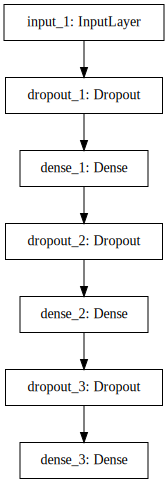

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))